# Training a Jet Tagging with **Recurrent Neural Network** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier with a GRU unit.
Gated Recurrent Units are one kind of RNNs. 

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [4]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

nb, if you are running locally you can skip the step below and change the paths later to point to the folder with your previous download of the datasets.

In [5]:
! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  15.5M      0 --:--:--  0:00:21 --:--:-- 18.9M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [20]:
target = np.array([])
jetList = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


*jetList*
[[ 1.58757828e+02  6.20679398e+01  4.26207962e+01 ...  4.97238711e-02
   2.42567196e-01  6.12323426e-17]
 [ 1.27314148e+02  5.00007515e+01  3.38473091e+01 ...  4.70003374e-02
   2.40211338e-01 -9.76750278e-04]
 [ 7.92414322e+01  3.14465923e+01  2.09029751e+01 ...  4.28280123e-02
   2.38133788e-01 -4.53256536e-04]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
**********
*Normalized jetList*
[[ 1.58757828e+02  6.20679398e+01  4.26207962e+01 ...  4.97238711e-02
   2.42567196e-01  6.12323426e-17]
 [ 1.27314148e+02  5.00007515e+01  3.38473091e+01 ...  4.70003374e-02
   2.40211338e-01 -9.76750278e-04]
 [ 7.92414322e+01  3.14465923e+01  2.09029751e+01 ...  4.28280123e-02
   2.38133788e-01 -4.53256536e-04]
 ...
 [

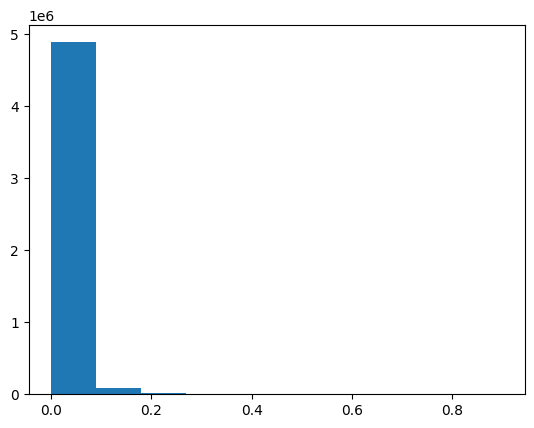

In [30]:
#normalizing to improve the efficiency

print("*jetList*")
print(jetList)
print("**********")

print("*Normalized jetList*")
jetList = jetList.reshape(50000*100, 16)
print(jetList)
print("**********")

plt.hist(jetList[:,4])
print(jetList.shape)

The dataset consists of 50000 with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target
#sequence up to 100 particles, internally it takes only the particles that are not 0

(33500, 100, 16) (16500, 100, 16) (33500, 5) (16500, 5)


# Building the RNN model

A recurrent neural network (RNN) is a type of NN which processes sequential data or time series data. They are commonly used for ordinal or temporal problems, such as natural language processing (NLP). They are distinguished by their “memory” as they take information from prior inputs to influence the current input and output.

<img src="https://github.com/saricongi/ML_course_Pavia_23/blob/main_v2/neural-networks/figures/rnn1.png?raw=1" alt="Drawing" style="width: 600px;"/>

In this notebook we treat the particles clustered by the jet algorithm as an ordered sequence processed through a type of RNN called [Gated Recurrent Units](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be). GRUs are improved version of standard RNN that solves the solves the vanishing gradient problem. The update and reset gates decide what information should be passed to the output making the model able to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction. The main ingredients are:

- number of hidden units: the size of the hidden state *ht*
- gates activation function (typically a sigmoid between 0 and 1 to either let no flow or complete flow of information throughout the gates). 
- current state activation function (typically a tanh between -1 and 1 to allow for increases and decreases in the state)

In [10]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GRU, Dropout, Masking
#GRU are more computational efficient, the input is the hidden state
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [11]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

In [12]:
####
inputList = Input(shape=(featureArrayLength))
x = Masking( mask_value = 0.0)(inputList)
# masking is inportant, it forgets the element in the inputList that are 0 -> you do the training adapting the length of the array, this is the power of RNN!
x = GRU(units=40, activation="tanh", recurrent_activation='sigmoid')(inputList)
#only one line of code, 40 = nb of units
x = Dropout(dropoutRate)(x)
#
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 16)]         0         
                                                                 
 gru (GRU)                   (None, 40)                6960      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0     

We now train the model

In [14]:
batch_size = 128
n_epochs = 200

In [15]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
262/262 - 12s - loss: 1.5573 - val_loss: 1.4380 - lr: 0.0010 - 12s/epoch - 46ms/step
Epoch 2/200
262/262 - 2s - loss: 1.4182 - val_loss: 1.3539 - lr: 0.0010 - 2s/epoch - 9ms/step
Epoch 3/200
262/262 - 3s - loss: 1.3895 - val_loss: 1.3472 - lr: 0.0010 - 3s/epoch - 11ms/step
Epoch 4/200
262/262 - 3s - loss: 1.3755 - val_loss: 1.3386 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 5/200
262/262 - 3s - loss: 1.3624 - val_loss: 1.3167 - lr: 0.0010 - 3s/epoch - 11ms/step
Epoch 6/200
262/262 - 3s - loss: 1.3476 - val_loss: 1.3069 - lr: 0.0010 - 3s/epoch - 10ms/step
Epoch 7/200
262/262 - 3s - loss: 1.3317 - val_loss: 1.2890 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 8/200
262/262 - 3s - loss: 1.3198 - val_loss: 1.2991 - lr: 0.0010 - 3s/epoch - 10ms/step
Epoch 9/200

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
262/262 - 3s - loss: 1.3129 - val_loss: 1.2946 - lr: 0.0010 - 3s/epoch - 10ms/step
Epoch 10/200
262/262 - 3s - loss: 1.3008 - val_loss: 1.2749 - lr: 

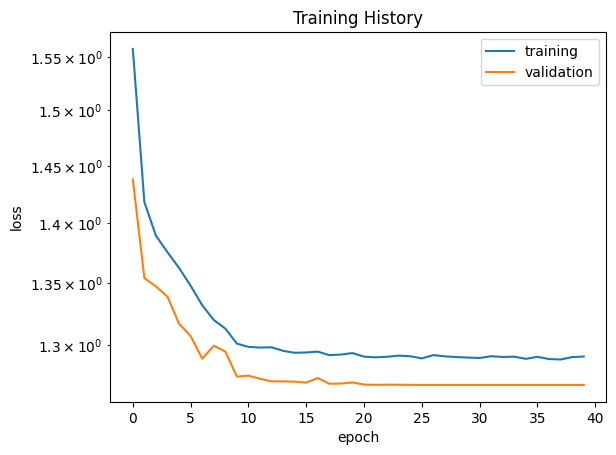

In [16]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [17]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

516/516 [==============================] - 3s 5ms/step


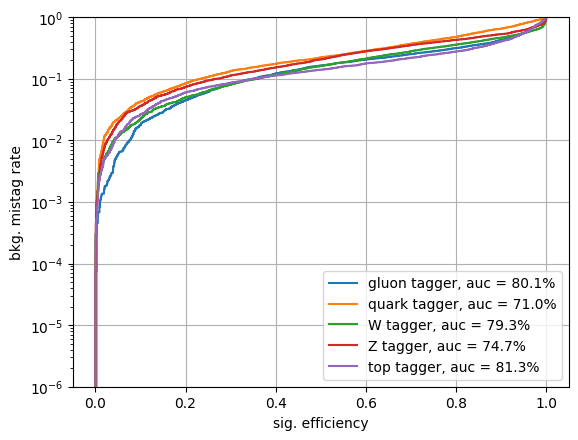

In [18]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()